In [29]:
# Clean Training Pipeline for Tune Embedding Experiments
# This notebook template can be copied for each experiment

import os
import json
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
from datetime import datetime
from pathlib import Path
from tensorflow.keras import layers, models
import collections
import random
import os
import sys
sys.path.append("../..")

import utils as ut

In [11]:
# ============================================================================
# EXPERIMENT CONFIGURATION
# ============================================================================

# Experiment metadata
EXPERIMENT_NAME = "experiment_1"  # Change this for each experiment
EXPERIMENT_DESCRIPTION = "cleaned up training pipeline, as well as raised learning rate and lowered batch size"

In [12]:
# Hyperparameters
CONFIG = {
    "experiment_name": EXPERIMENT_NAME,
    "description": EXPERIMENT_DESCRIPTION,
    "model_params": {
        "emb_dim": 32,
        "rnn_units": 32,
        "dropout_rate": 0.1,  # Add regularization
        "l2_reg": 0.001       # L2 regularization
    },
    "training_params": {
        "batch_size": 64,
        "learning_rate": 0.01,
        "epochs": 20,
        "margin": 0.3,
        "batch_tunes": 32,
        "per_tune": 2
    },
    "data_params": {
        "min_tune_settings": 2,
        "max_sequence_length": 512
    }
}

In [13]:
experiment_dir = ut.setup_experiment_directories(EXPERIMENT_NAME)

✓ Created directory: ../experiment_1
✓ Created directory: ../experiment_1/checkpoints
✓ Created directory: ../experiment_1/logs
✓ Created directory: ../experiment_1/plots
✓ Created directory: ../saved_models
✓ Created directory: ../tokenized_data


In [14]:
# Save experiment configuration
config_path = experiment_dir / "config.json"
with open(config_path, 'w') as f:
    json.dump(CONFIG, f, indent=2)
print(f"✓ Saved config to: {config_path}")

✓ Saved config to: ../experiment_1/config.json


In [15]:
# ============================================================================
# MODEL ARCHITECTURE
# ============================================================================

def create_tune_embedding_model(vocab_size, config):
    """
    Create tune embedding model with proper saving/loading support
    """
    model_params = config["model_params"]
    
    # Define inputs
    notes_in = layers.Input(shape=(None,), dtype="int32", name="note_ids")
    durs_in = layers.Input(shape=(None,), dtype="float32", name="durations")

    # Note embeddings with regularization
    note_emb = layers.Embedding(
        input_dim=vocab_size,
        output_dim=model_params["emb_dim"],
        mask_zero=True,
        embeddings_regularizer=tf.keras.regularizers.l2(model_params["l2_reg"]),
        name="note_embedding"
    )(notes_in)

    # Duration features - using Reshape instead of Lambda for better saving
    dur_feat = layers.Reshape((-1, 1), name="duration_reshape")(durs_in)
    
    # Duration embedding with regularization
    dur_emb = layers.TimeDistributed(
        layers.Dense(
            model_params["emb_dim"], 
            kernel_regularizer=tf.keras.regularizers.l2(model_params["l2_reg"]),
            name="duration_dense"
        ),
        name="duration_embedding"
    )(dur_feat)

    # Combine embeddings
    x = layers.Add(name="combine_embeddings")([note_emb, dur_emb])
    
    # Add dropout for regularization
    x = layers.Dropout(model_params["dropout_rate"], name="embedding_dropout")(x)

    # Bidirectional GRU with regularization
    rnn_out = layers.Bidirectional(
        layers.GRU(
            model_params["rnn_units"], 
            return_sequences=True,
            dropout=model_params["dropout_rate"],
            recurrent_dropout=model_params["dropout_rate"],
            kernel_regularizer=tf.keras.regularizers.l2(model_params["l2_reg"]),
            name="gru"
        ),
        name="bidirectional_gru"
    )(x)

    # Global average pooling
    tune_vec = layers.GlobalAveragePooling1D(name="global_pooling")(rnn_out)
    
    # Additional dense layer before normalization (optional)
    tune_vec = layers.Dense(
        2 * model_params["rnn_units"],
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(model_params["l2_reg"]),
        name="dense_before_norm"
    )(tune_vec)
    
    tune_vec = layers.Dropout(model_params["dropout_rate"], name="final_dropout")(tune_vec)

    # L2 normalization using custom layer instead of Lambda
    class L2Normalize(layers.Layer):
        def __init__(self, **kwargs):
            super(L2Normalize, self).__init__(**kwargs)
        
        def call(self, inputs):
            return tf.math.l2_normalize(inputs, axis=1)
        
        def get_config(self):
            return super(L2Normalize, self).get_config()

    tune_emb = L2Normalize(name="l2_normalize")(tune_vec)

    # Build model
    model = tf.keras.Model(
        inputs=[notes_in, durs_in], 
        outputs=tune_emb, 
        name=f"tune_embedder_{EXPERIMENT_NAME}"
    )
    
    return model

In [23]:

# ============================================================================
# CALLBACKS AND MONITORING
# ============================================================================

def create_callbacks_with_validation(experiment_dir, config, use_validation=True):
    """Create callbacks, optionally including validation monitoring"""
    
    callbacks = []
    
    # Model checkpointing
    if use_validation:
        # Monitor validation loss if available
        monitor_metric = 'val_loss'
        mode = 'min'
    else:
        # Fall back to training loss
        monitor_metric = 'loss'  
        mode = 'min'
    
    # Best model checkpoint
    best_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=experiment_dir / "checkpoints" / "best_weights.weights.h5",
        save_weights_only=True,
        save_best_only=True,
        monitor=monitor_metric,
        mode=mode,
        verbose=1
    )
    callbacks.append(best_checkpoint)
    
    # Regular checkpoints
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=experiment_dir / "checkpoints" / "weights_epoch_{epoch:02d}.weights.h5",
        save_weights_only=True,
        save_freq='epoch',
        verbose=0
    )
    callbacks.append(checkpoint_callback)
    
    # CSV logger
    csv_logger = tf.keras.callbacks.CSVLogger(
        experiment_dir / "logs" / "training_log.csv",
        append=True
    )
    callbacks.append(csv_logger)
    
    # Learning rate reduction
    lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
        monitor=monitor_metric,
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
    callbacks.append(lr_reducer)
    
    # Early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor=monitor_metric,
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
    callbacks.append(early_stopping)

    #similarity_callback = ut.TuneSimilarityCallback(val_df)
    #callbacks.append(similarity_callback)
    
    return callbacks


In [24]:
print(f"Starting {EXPERIMENT_NAME}")
print("="*50)

# Load data
train_df, val_df, vocab_list, split_info = ut.load_training_data()
print("✓ Data loaded")
vocab_size = len(vocab_list) + 2

# Create model
model = create_tune_embedding_model(vocab_size, CONFIG)
print("✓ Model created")

# Compile model
optimizer = tf.keras.optimizers.Adam(
    learning_rate=CONFIG["training_params"]["learning_rate"]
)

model.compile(
    optimizer=optimizer,
    loss=ut.batch_hard_triplet_loss(margin=CONFIG["training_params"]["margin"])
)

print("✓ Model compiled")
model.summary()

# transform into datasets
train_ds = ut.make_balanced_ds(train_df, CONFIG["training_params"]["batch_tunes"], CONFIG["training_params"]["per_tune"])
val_ds = ut.make_balanced_ds(val_df, CONFIG["training_params"]["batch_tunes"], CONFIG["training_params"]["per_tune"])
print("✓ Training dataset created")

# Create callbacks
callbacks = create_callbacks_with_validation(
    experiment_dir, CONFIG, use_validation=(val_ds is not None)
)
print("✓ Callbacks created")
steps_per_epoch = len(train_df) // (CONFIG["training_params"]["per_tune"] * CONFIG["training_params"]["batch_tunes"])
validation_steps = len(val_df) // (CONFIG["training_params"]["per_tune"] * CONFIG["training_params"]["batch_tunes"]) 
print(f"Steps per epoch: {steps_per_epoch}")



Starting experiment_1
📁 Loading training data...
✓ Train: 35,415 samples from 15,418 tunes
✓ Val:   7,509 samples from 3,304 tunes
✓ Vocab: 64 unique notes
✓ Data loaded
✓ Model created
✓ Model compiled


Model: "tune_embedder_experiment_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ durations           │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ note_ids            │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duration_reshape    │ (None, None, 1)   │          0 │ durations[0][0]   │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ note_embedding      │ (None, None, 32)  │      2,112 │ note_ids[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duration_embedding  │ (None, None, 32)  │         64 │ duration_reshape… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ combine_embeddings  │ (None, None, 32)  │          0 │ note_embedding[0… │
│ (Add)               │                   │            │ duration_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_dropout   │ (None, None, 32)  │          0 │ combine_embeddin… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_gru   │ (None, None, 64)  │     12,672 │ embedding_dropou… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_pooling      │ (None, 64)        │          0 │ bidirectional_gr… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_before_norm   │ (None, 64)        │      4,160 │ global_pooling[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_dropout       │ (None, 64)        │          0 │ dense_before_nor… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l2_normalize        │ (None, 64)        │          0 │ final_dropout[0]… │
│ (L2Normalize)       │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,008 (74.25 KB)

 Trainable params: 19,008 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

✓ Training dataset created
✓ Callbacks created
Steps per epoch: 553


In [25]:
# Train model
print("Starting training...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=CONFIG["training_params"]["epochs"],
    callbacks=callbacks
)


Starting training...
Epoch 1/20
553/553 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.4457
Epoch 1: val_loss improved from inf to 0.30257, saving model to ../experiment_1/checkpoints/best_weights.weights.h5
553/553 ━━━━━━━━━━━━━━━━━━━━ 1588s 3s/step - loss: 0.4456 - val_loss: 0.3026 - learning_rate: 0.0100
Epoch 2/20
553/553 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.4082
Epoch 2: val_loss improved from 0.30257 to 0.30053, saving model to ../experiment_1/checkpoints/best_weights.weights.h5
553/553 ━━━━━━━━━━━━━━━━━━━━ 1548s 3s/step - loss: 0.4082 - val_loss: 0.3005 - learning_rate: 0.0100
Epoch 3/20
553/553 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.4055
Epoch 3: val_loss improved from 0.30053 to 0.30024, saving model to ../experiment_1/checkpoints/best_weights.weights.h5
553/553 ━━━━━━━━━━━━━━━━━━━━ 1623s 3s/step - loss: 0.4055 - val_loss: 0.3002 - learning_rate: 0.0100
Epoch 4/20
553/553 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.4059
Epoch 4: val_loss did not improve from 0.30024
553/553 ━

In [31]:
def save_model_and_weights(model, experiment_dir, experiment_name):
    """Save model in multiple formats for reliability"""
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Save weights to experiment directory
    weights_path = experiment_dir / "checkpoints" / f"final_weights_{timestamp}.weights.h5"
    model.save_weights(weights_path)
    print(f"✓ Saved weights to: {weights_path}")
    
    # Save weights to main saved_models directory
    main_weights_path = Path("../saved_models") / f"{experiment_name}.weights.h5"
    model.save_weights(main_weights_path)
    print(f"✓ Saved weights to: {main_weights_path}")
    
    # Save model architecture
    architecture_path = experiment_dir / "model_architecture.json"
    with open(architecture_path, 'w') as f:
        f.write(model.to_json())
    print(f"✓ Saved architecture to: {architecture_path}")
    
    # Try to save full model (might fail with Lambda layers)
    try:
        model_path = experiment_dir / "checkpoints" / f"full_model_{timestamp}.keras"
        model.save(model_path)
        print(f"✓ Saved full model to: {model_path}")
    except Exception as e:
        print(f"⚠ Could not save full model: {e}")
    
    return weights_path, main_weights_path

In [32]:
# Save final model
save_model_and_weights(model, experiment_dir, EXPERIMENT_NAME)

✓ Saved weights to: ../experiment_1/checkpoints/final_weights_20250604_224116.weights.h5
✓ Saved weights to: ../saved_models/experiment_1.weights.h5
✓ Saved architecture to: ../experiment_1/model_architecture.json
✓ Saved full model to: ../experiment_1/checkpoints/full_model_20250604_224116.keras


(PosixPath('../experiment_1/checkpoints/final_weights_20250604_224116.weights.h5'),
 PosixPath('../saved_models/experiment_1.weights.h5'))

In [33]:
# Save training history
history_path = experiment_dir / "training_history.pkl"
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f)
print(f"✓ Saved training history to: {history_path}")

print(f"✓ {EXPERIMENT_NAME} completed!")

✓ Saved training history to: ../experiment_1/training_history.pkl
✓ experiment_1 completed!


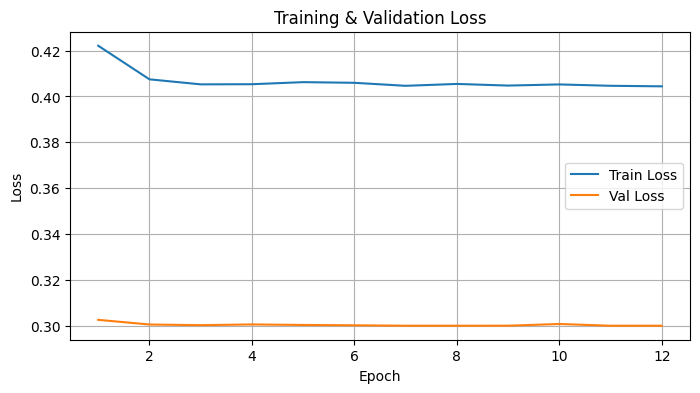

In [34]:
import matplotlib.pyplot as plt

# history is the History object returned by model.fit(...)
train_loss = history.history['loss']
val_loss   = history.history.get('val_loss', None)
epochs     = range(1, len(train_loss) + 1)

plt.figure(figsize=(8,4))
plt.plot(epochs, train_loss,  label='Train Loss')
if val_loss is not None:
    plt.plot(epochs, val_loss,  label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()